In [54]:
! pip install joblib


In [40]:
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

df = pd.read_csv('./data/IMDB-Dataset.csv')

df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Pre-processing
- Xóa thẻ html (Beautiful soup), http(re.sub)
- Expanding contraction : mở rộng từ viết tắt thành dạng đầy đủ của chúng
- thêm khoảng trắng sau mỗi dấu chấm kết thúc câu
- xóa các icon (re.compile)
- remove punctuation, stopword, string not alphabet and make text lowercase

In [41]:
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from nltk.corpus import wordnet
import contractions

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [42]:
def expand_contraction(text):
    return contractions.fix(text)

def punctual_removal(text:str):
    translator = str.maketrans('','', string.punctuation)
    return text.translate(translator)


def get_postag(word):
    tag = nltk.pos_tag([word])[0][1][0]
    tag_dict = {
        "N": wordnet.NOUN,
        "J": wordnet.ADJ,
        "V": wordnet.VERB,
        "R": wordnet.ADV
    }
    
    return tag_dict.get(tag, wordnet.NOUN)

In [43]:

df.drop_duplicates(inplace=True)  # xóa hàng trùng


def preprocessing(text : str):
    soup = BeautifulSoup(text, 'html.parser')  # xóa thẻ html

    soup = soup.get_text()

    text = re.sub(r'http\S+', '', soup)       # xóa https
    text = expand_contraction(text)           # mở rộng từ
    # thêm khoảng trắng sau kết thúc câu
    text = re.sub(r'([.?,!])(?=\S+)', r'\1 ', text)

    emoji_clean = re.compile(r"[\U0001F600-\U0001F64F"  # Emoticons
                            r"\U0001F300-\U0001F5FF"   # Symbols & Pictographs
                            r"\U0001F680-\U0001F6FF"   # Transport & Map Symbols
                            r"\U0001F1E0-\U0001F1FF"   # Flags
                            r"\u2702-\u27B0"           # Dingbats and Other Symbols
                            r"\u24C2-\U0001F251]",
                            flags=re.UNICODE)
    clean_text = emoji_clean.sub('', text)             # xóa emoji

    # remove punctual
    clean_text = punctual_removal(clean_text)

    # lower and remove stopword and string is not alphabet
    stop = set(stopwords.words('english'))
    clean_text = " ".join([word.lower() for word in clean_text.split(
    ) if word not in stop or word.isalpha()])

    # transform to original word
    lemmatizer = WordNetLemmatizer()
    clean_text = " ".join([lemmatizer.lemmatize(word, pos=get_postag(word)) for word in clean_text.split()])

    return clean_text


print(f"Bộ nhớ sử dụng: {df.memory_usage(deep=True).sum() / 1024 ** 2:.2f} MB")

df['review'] = df['review'].progress_apply(preprocessing)

print(f"Bộ nhớ sử dụng: {df.memory_usage(deep=True).sum() / 1024 ** 2:.2f} MB")

Bộ nhớ sử dụng: 77.57 MB


  2%|▏         | 871/49582 [01:08<46:01, 17.64it/s]  C:\Users\ASUS\AppData\Local\Temp\ipykernel_21452\3765219338.py:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')  # xóa thẻ html
100%|██████████| 49582/49582 [1:05:14<00:00, 12.67it/s]

Bộ nhớ sử dụng: 63.47 MB


### Phân tích dữ liệu:
- biểu đồ tròn : Thống kê số lượng các nhãn trong bộ dữ liệu (format lại hiển thị thêm số phần tử. Công thức $\text{Giá trị của phần tử} = \frac{\text{pct}}{100} \times \text{total}$)

In [44]:
def custom_autopct(pct, data):
    count = int((pct  * sum(data)) / 100)
    return '{:.1f}%\n({:d})'.format(pct, count)

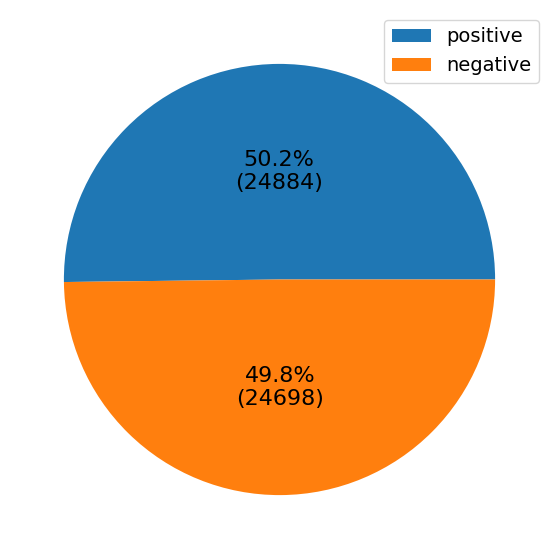

In [45]:
import matplotlib.pyplot as plt

len_positive = len(df.loc[df['sentiment'] == 'positive'])
len_negative = len(df.loc[df['sentiment'] == 'negative'])

data = [len_positive, len_negative]

plt.figure(figsize=(10, 7))
plt.pie(x=data, autopct=lambda pct: custom_autopct(pct, data), textprops={'fontsize': 16}, pctdistance=0.5)
labels=["positive", "negative"]
plt.legend(labels, loc="upper right", prop={'size': 14})

Text(0.5, 1.0, 'Words in negative reviews')

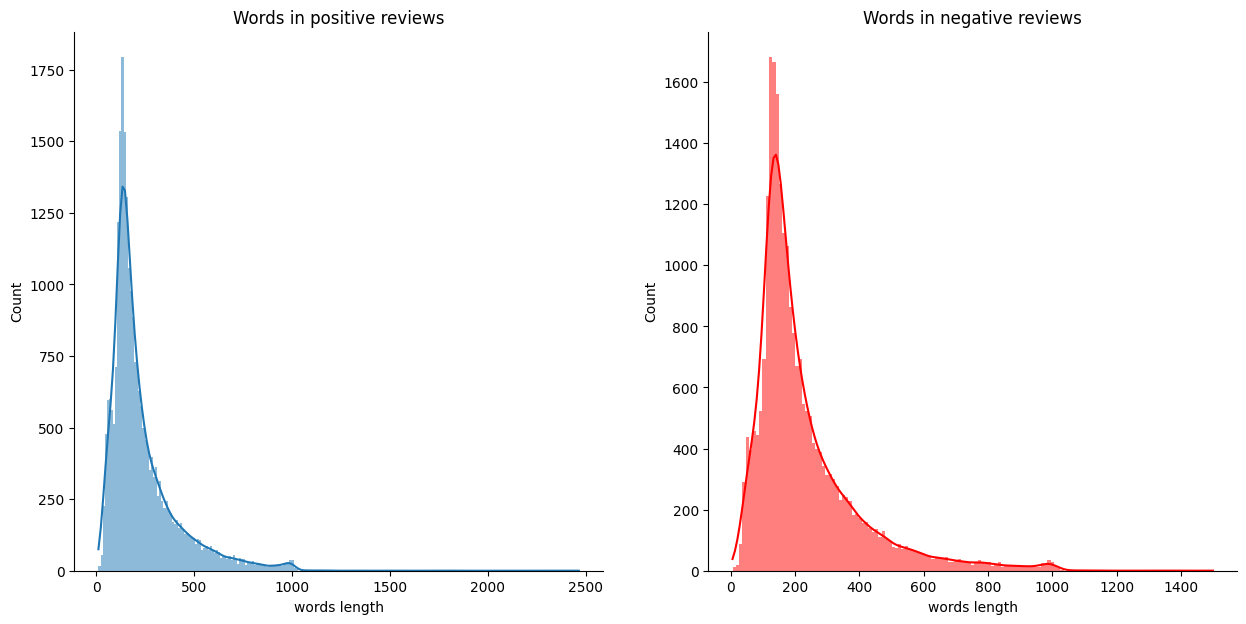

In [46]:
import seaborn as sns
df['word_length'] = df['review'].apply(lambda x : len(x.split()))

fig, ax = plt.subplots(1, 2, figsize = (15, 7))

positive_msg = df.loc[df['sentiment'] == 'positive']
negative_msg = df.loc[df['sentiment'] == 'negative']


sns.despine()  # Loại bỏ viền top và right mặc định
sns.histplot(data=positive_msg, x="word_length", kde = True, ax=ax[0], edgecolor = None)
ax[0].set_xlabel('words length')
ax[0].set_title("Words in positive reviews")


sns.histplot(data=negative_msg, x="word_length", kde=True,
             ax=ax[1], color='red', edgecolor=None)
ax[1].set_xlabel('words length')
ax[1].set_title("Words in negative reviews")

### Chia tập train và test

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.preprocessing import LabelEncoder

label_encoded = LabelEncoder()

y = df['sentiment']
x = df['review']
y = label_encoded.fit_transform(y)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, 
    test_size = 0.2,
    random_state = 42
)


### Vectorize text
- xài max_features =10000 , nghĩa là khi fit thì model chỉ lấy ra 10000 có tần suất xuất hiện cao nhất

In [50]:
tfidf_vectorizer = TfidfVectorizer(max_features =10000)
tfidf_vectorizer.fit_transform(x_train, y_train)

x_train_encoded = tfidf_vectorizer.transform(x_train)
x_test_encoded = tfidf_vectorizer.transform(x_test)

### Huấn luyện và đánh giá mô hình

In [68]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
dt_classifier = DecisionTreeClassifier (
 criterion ='entropy',
 random_state =42, 
 max_depth=4
)
dt_classifier.fit(x_train_encoded, y_train)
y_pred = dt_classifier.predict(x_test_encoded)
accuracy_score(y_pred, y_test)

0.6947665624684884

In [69]:
import joblib
# Lưu mô hình ra file
joblib.dump(dt_classifier, 'text_classification_model.joblib')

['text_classification_model.joblib']

In [70]:
# Tải mô hình từ file
dt_classifier = joblib.load('text_classification_model.joblib')

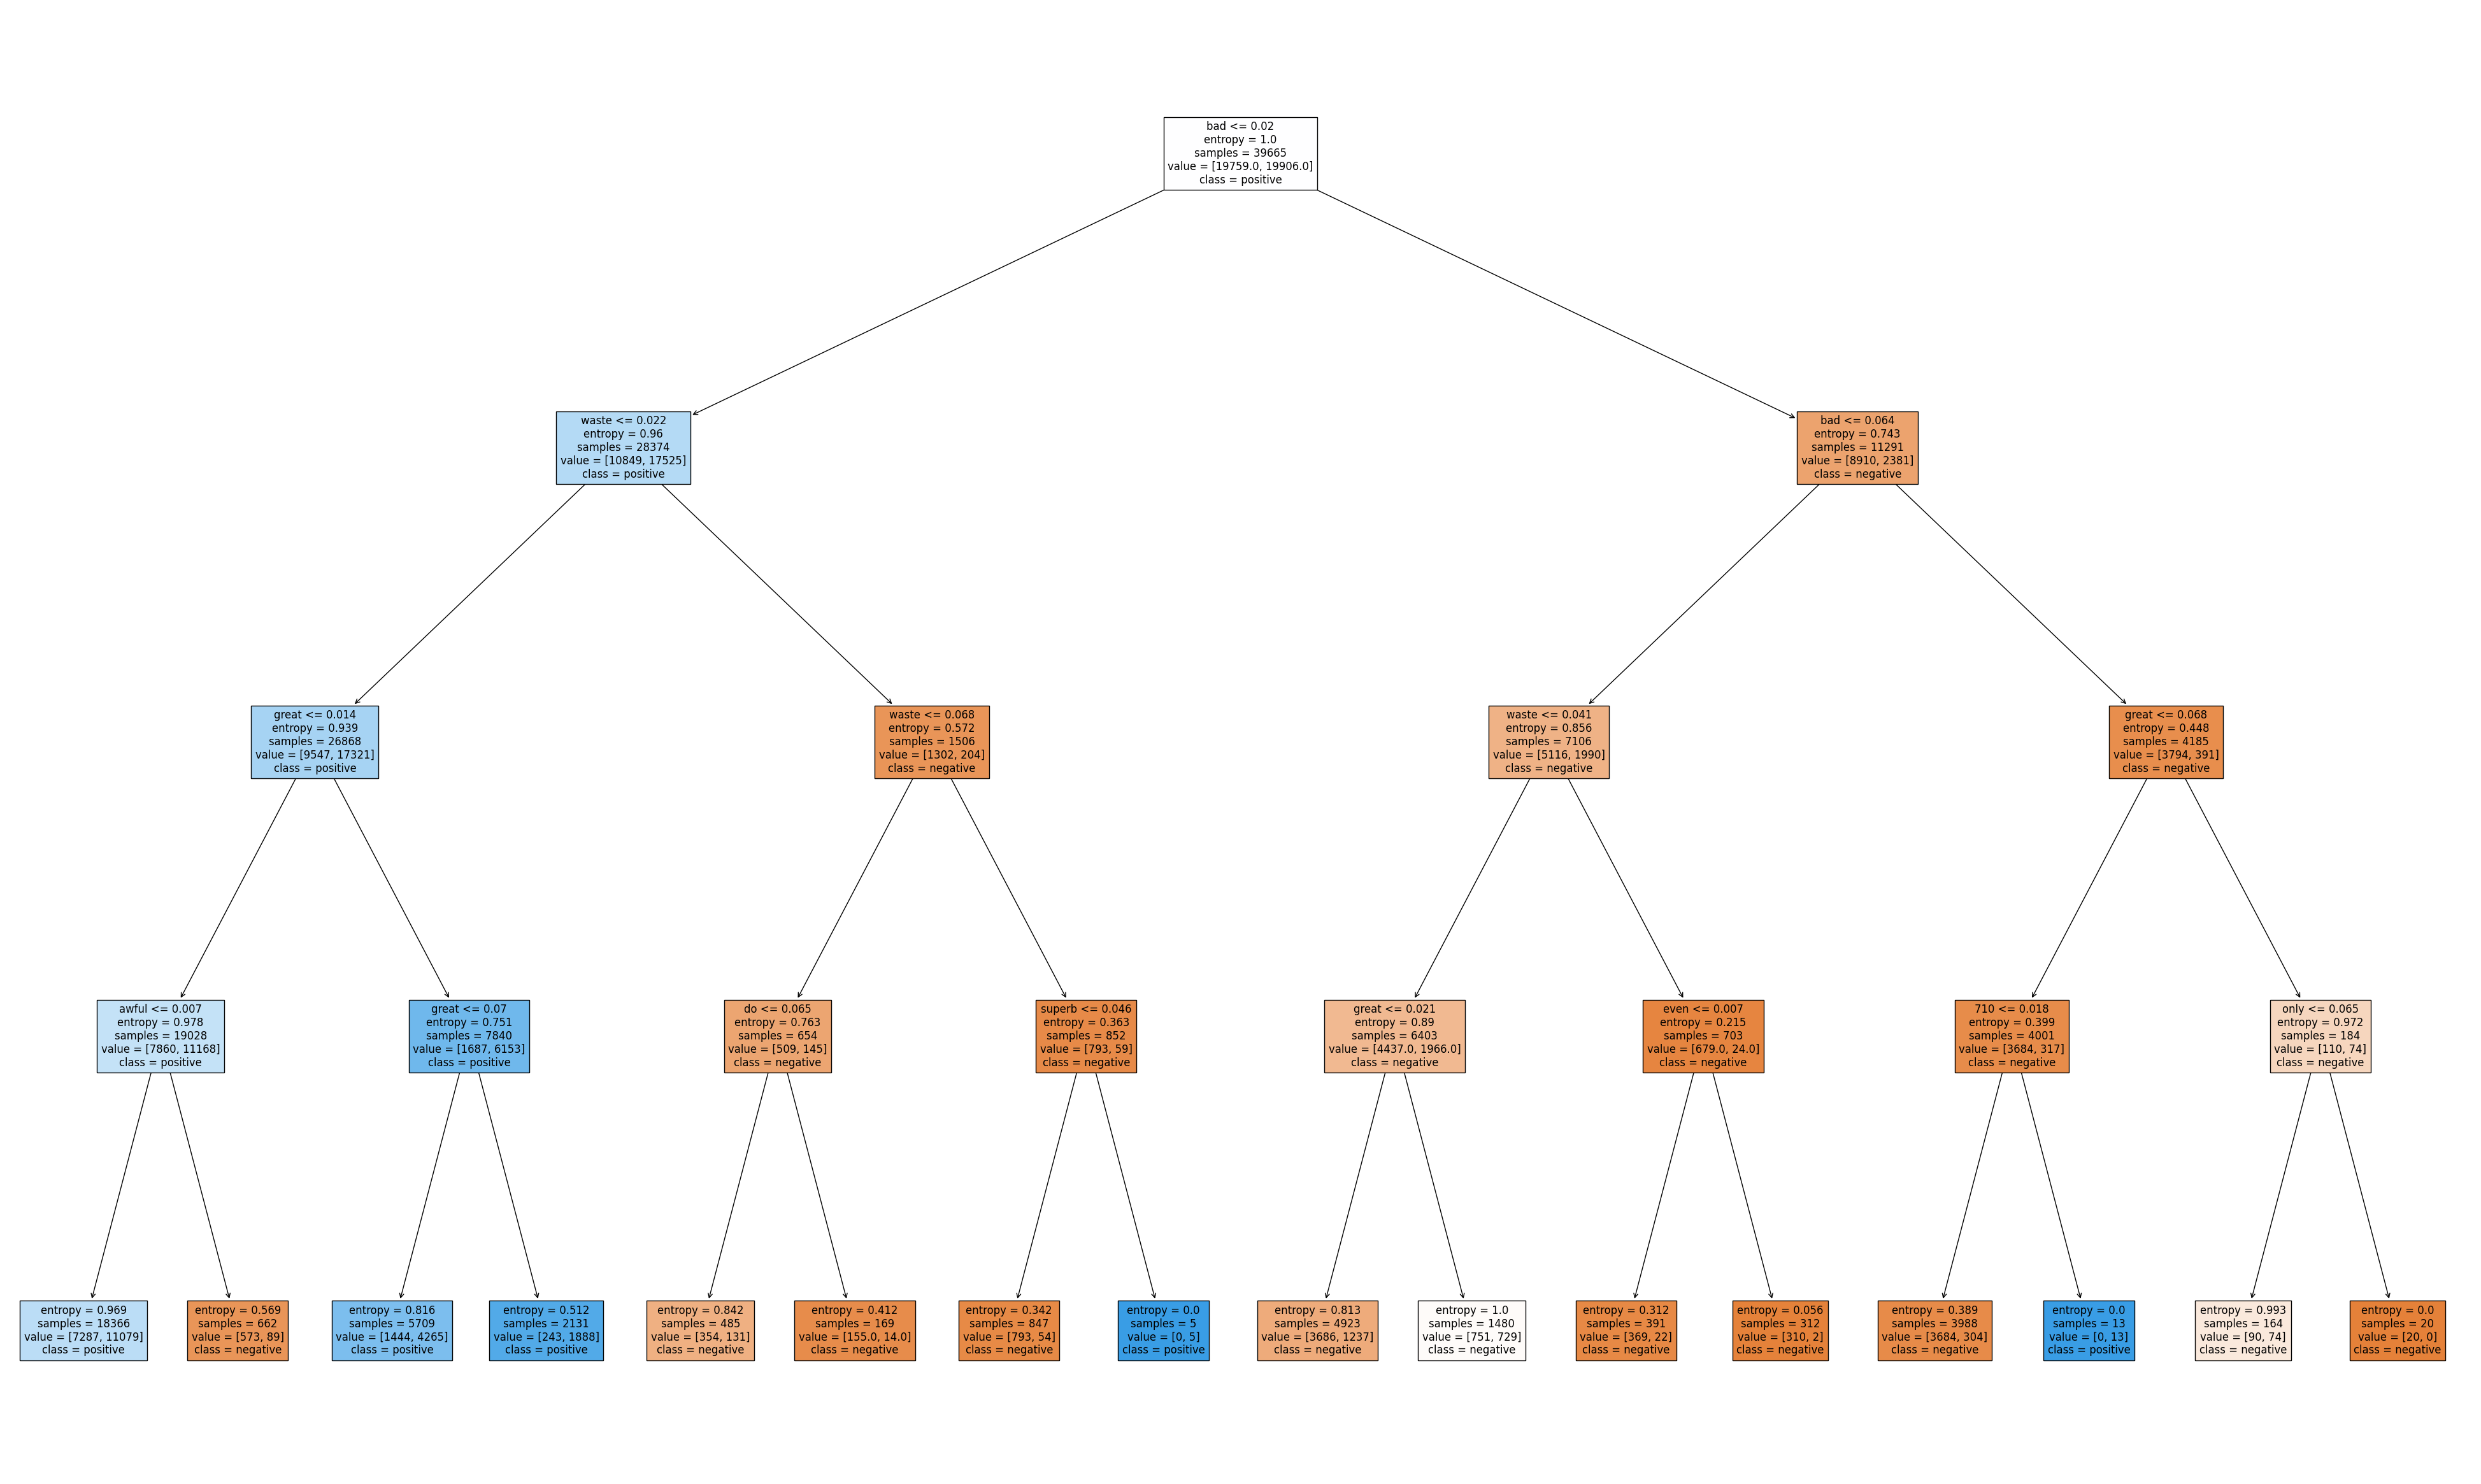

In [71]:
import graphviz

class_names = label_encoded.classes_
feature_names = tfidf_vectorizer.get_feature_names_out()
fig = plt.figure(figsize=(50, 30))
_ = tree.plot_tree(dt_classifier, feature_names=feature_names, class_names=class_names, filled=True)